In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

2024-11-25 21:26:07.438423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 21:26:07.487540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732587967.505000  498311 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732587967.510400  498311 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 21:26:07.528993: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set paths
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1"
dataset_path = tf.keras.utils.get_file('ls_model_data_five.zip', origin=dataset_url, extract=True)
extracted_dir = os.path.splitext(dataset_path)[0]



In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the dataset directory
dataset_dir = '/home/mjp2da/.keras/datasets/ls_model_data_five_extracted'

# Define data generators with a validation split
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)

# Training generator
train_generator = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # Match model input size
    batch_size=32,
    class_mode='binary',    # Use 'binary' for two classes
    subset='training'       # Specify training data subset
)

# Validation generator
val_generator = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'     # Specify validation data subset
)

# Output dataset stats
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")


Found 5580 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.
Training samples: 5580
Validation samples: 1394


In [7]:
# Load DenseNet121 and build the model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use 2 units with softmax for multi-class
])

2024-11-25 21:35:41.363907: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [9]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Save the model
model.save('densenet_landslide_model.h5')

/home/mjp2da/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6246 - loss: 0.7211

/home/mjp2da/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/174 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.6251 - loss: 0.7203 - val_accuracy: 0.6337 - val_loss: 0.6457
Epoch 2/10
  1/174 ━━━━━━━━━━━━━━━━━━━━ 2:37 912ms/step - accuracy: 0.7500 - loss: 0.4902

2024-11-25 21:40:31.693740: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-25 21:40:32.269813: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7500 - loss: 0.4902 - val_accuracy: 0.6111 - val_loss: 0.6332
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.8335 - loss: 0.3718 - val_accuracy: 0.6417 - val_loss: 0.6830
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.2976 - val_accuracy: 0.7778 - val_loss: 0.4781
Epoch 5/10


2024-11-25 21:44:31.552856: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.8719 - loss: 0.3011 - val_accuracy: 0.6170 - val_loss: 0.7395
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8438 - loss: 0.2926 - val_accuracy: 0.5000 - val_loss: 0.8499
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9067 - loss: 0.2365 - val_accuracy: 0.6170 - val_loss: 0.8115
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9688 - loss: 0.1638 - val_accuracy: 0.7222 - val_loss: 0.5347
Epoch 9/10


2024-11-25 21:52:25.180953: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.9129 - loss: 0.2087 - val_accuracy: 0.6250 - val_loss: 0.8055
Epoch 10/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.1866 - val_accuracy: 0.5556 - val_loss: 0.8378


In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6164 - loss: 0.8178
Validation Accuracy: 62.70%


In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

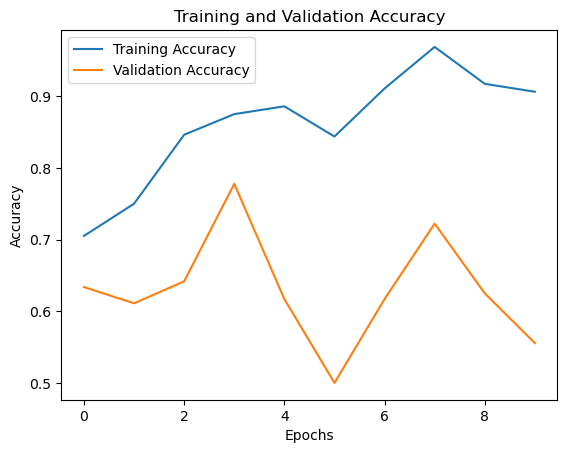

In [19]:
# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

In [21]:
# Download and extract the test dataset
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"
test_dataset_path = tf.keras.utils.get_file('test_google_images_landslide_three.zip', origin=test_dataset_url, extract=True)
test_extracted_dir = os.path.splitext(test_dataset_path)[0]

# Check test dataset structure
print(f"Test dataset extracted to: {test_extracted_dir}")

79971293/79971293 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Test dataset extracted to: /home/mjp2da/.keras/datasets/test_google_images_landslide_three_extracted


In [22]:
# Data preprocessing for the test set

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_extracted_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Use 'categorical' for multi-class classification
    shuffle=False  # Keep data in the same order for consistent evaluation
)

Found 114 images belonging to 1 classes.


In [23]:
# Load the saved model
model = tf.keras.models.load_model('densenet_landslide_model.h5')

In [24]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on the test set
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Threshold for binary classification

/home/mjp2da/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 841ms/step - accuracy: 0.2708 - loss: 1.9235
Test Accuracy: 23.68%
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [25]:
# Display some results
for i, (img, label) in enumerate(zip(test_generator.filenames, predicted_classes)):
    print(f"Image: {img}, Predicted: {'Landslide' if label[0] == 1 else 'Non-Landslide'}")
    if i >= 9:  # Show the first 10 predictions
        break

Image: Google_Earth_Images/landslides/NASA_Arc_6038_vylg.jpg, Predicted: Non-Landslide
Image: Google_Earth_Images/landslides/NASA_Arc_8334_vylg.jpg, Predicted: Landslide
Image: Google_Earth_Images/landslides/NASA_GoogE_10521_large.jpg, Predicted: Non-Landslide
Image: Google_Earth_Images/landslides/NASA_GoogE_11540_cat.jpg, Predicted: Landslide
Image: Google_Earth_Images/landslides/NASA_GoogE_13710_cat.jpg, Predicted: Landslide
Image: Google_Earth_Images/landslides/NASA_GoogE_14445_cat.jpg, Predicted: Landslide
Image: Google_Earth_Images/landslides/nasa_g_1256m_10038_2018_large.jpg, Predicted: Landslide
Image: Google_Earth_Images/landslides/nasa_g_1950m_14143_2018_vylg.jpg, Predicted: Landslide
Image: Google_Earth_Images/landslides/nasa_g_2000m_10521_2017_large_two.jpg, Predicted: Non-Landslide
Image: Google_Earth_Images/landslides/nasa_g_2000m_14329_2011_large.jpg, Predicted: Landslide
